In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using Theano backend.


In [2]:
from datetime import date
today = date.today()
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            plt.title("Stock Adjusted Price Historical Data")
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


In [3]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single

    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


## Technical Indicators

### Simple Daily Return

In [4]:
sdr = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=False, stock_value='Adj Close')
sdr

Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,104.081535,25.400000,NaN,23.886580,NaN
2017-01-04,26.887548,103.910828,26.200001,NaN,24.076221,NaN
2017-01-05,27.146002,104.998009,26.400000,NaN,24.731359,NaN
2017-01-06,27.041008,104.494850,27.400000,NaN,24.507233,NaN
2017-01-09,27.032928,104.476868,28.400000,NaN,24.593435,NaN
...,...,...,...,...,...,...
2021-02-08,34.820000,164.919998,319.929993,185.979996,50.060001,119.500000
2021-02-09,34.970001,166.270004,315.869995,179.520004,50.410000,117.529999
2021-02-10,34.740002,166.809998,298.359985,179.339996,49.970001,119.349998


In [5]:
d_simple_returns = sdr.pct_change(1)

In [6]:
(26.887548/26.653324) - 1

0.008787796974216056

Text(0, 0.5, 'Daily Simple Returns')

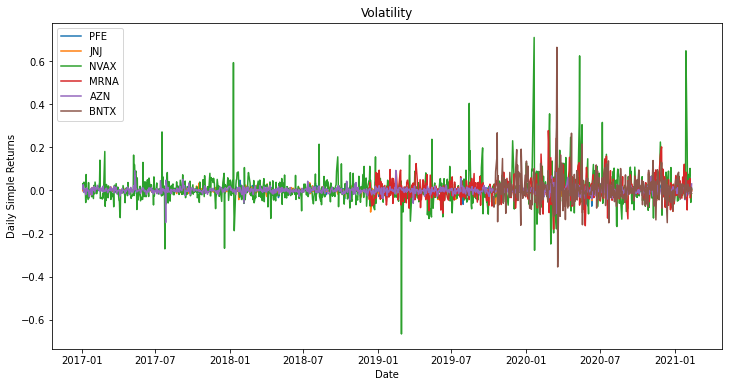

In [7]:
#visualize stocks daily returns
plt.figure(figsize=(12,6))
#loop through each stock and plot simple returns
for c in d_simple_returns.columns.values:
    plt.plot(d_simple_returns.index, d_simple_returns[c], label=c)
#plt.title(title)
#plt.ylabel(col + ' Price', fontsize=18)
plt.legend(loc='upper left', fontsize=10)
plt.title('Volatility')
plt.xlabel('Date')
plt.ylabel('Daily Simple Returns')

### Average Daily Return

In [8]:
d_simple_returns.std()
mean_return = d_simple_returns.mean()
print('The Daily Mean Simple Return')
mean_return

The Daily Mean Simple Return


Symbols
PFE     0.000362
JNJ     0.000541
NVAX    0.005262
MRNA    0.005502
AZN     0.000882
BNTX    0.009189
dtype: float64

## Forecasting
### Long Short Term Memory (LSTM)

Dataframe has 534 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,41.271347,40.455406,40.910816,41.034157,26430315.0,37.603287
2019-01-03,41.119545,39.800758,41.024670,39.886147,28503533.0,36.551258
2019-01-04,41.129032,40.094875,40.265656,40.796963,27145348.0,37.385921
2019-01-07,41.385201,40.664139,40.863377,41.015179,20995469.0,37.585892
2019-01-08,41.461102,40.939278,41.328274,41.204933,19677231.0,37.759781
...,...,...,...,...,...,...
2021-02-08,35.009998,34.740002,34.959999,34.820000,31633900.0,34.820000
2021-02-09,35.060001,34.759998,34.799999,34.970001,30170200.0,34.970001
2021-02-10,35.080002,34.700001,35.000000,34.740002,29039900.0,34.740002


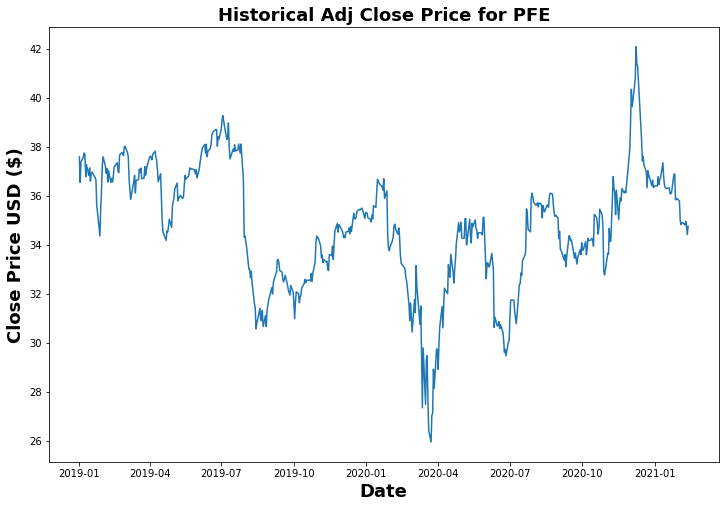

In [9]:
#start='01-01-2019',end='today',
df = single_stock_data('PFE', start='01-01-2019',end='today',plot=True,stock_value='Adj Close')
df

In [11]:
(24.905140 / 25.028662) -1

-0.00493522186683415

In [13]:
def delta_time_series(data):
    data_1 = data.pct_change(1)
    data_1 = data_1.rename(columns={"Adj Close": "Percent_Chg"})
    #return data[1:]- data[:-1]
    data_1 = data_1.dropna()
    return data_1

In [14]:
dataset_delta_AMAZN = delta_time_series(df)
dataset_delta_AMAZN

,High,Low,Open,Close,Volume,Percent_Chg
Date,,,,,,
2019-01-03,-0.003678,-0.016182,0.002783,-0.027977,0.078441,-0.027977
2019-01-04,0.000231,0.007390,-0.018501,0.022835,-0.047650,0.022835
2019-01-07,0.006228,0.014198,0.014844,0.005349,-0.226554,0.005349
2019-01-08,0.001834,0.006766,0.011377,0.004626,-0.062787,0.004626
2019-01-09,-0.000687,0.001159,-0.002296,-0.002072,0.021870,-0.002072
...,...,...,...,...,...,...
2021-02-08,-0.001996,-0.001150,0.001146,-0.002864,-0.000354,-0.002864
2021-02-09,0.001428,0.000576,-0.004577,0.004308,-0.046270,0.004308
2021-02-10,0.000570,-0.001726,0.005747,-0.006577,-0.037464,-0.006577


In [15]:
#df_data.shape

In [16]:
def plot_delta(data,symbol=None):
    plt.figure(figsize=(12,6))
    #plt.plot(delta_time_series(data))
    plt.plot(data)
    label_font = {'weight':'bold','size':18}
    plt.title('Daily Percentage Price Change',fontdict=label_font)
    plt.xlabel('Dates',fontdict=label_font)
    plt.ylabel('close')
    plt.show()

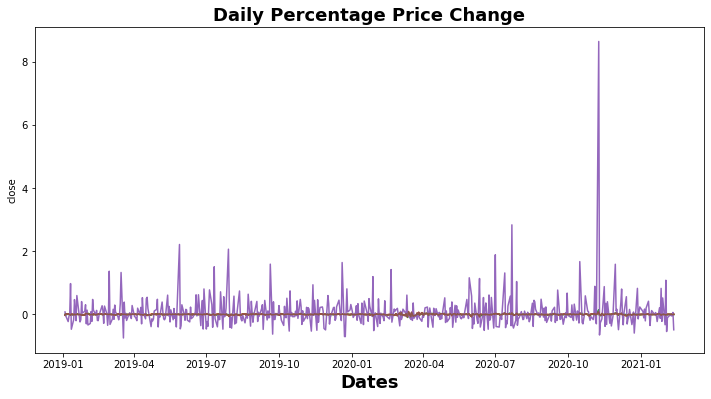

In [17]:
#simple daily return
#centered aroun d 0
plot_delta(dataset_delta_AMAZN)

In [18]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [19]:
def binary_accuracy(a, b):
    '''
    Helper function to compute the match score of two 
    binary numpy arrays.
    '''
    assert len(a) == len(b)
    return (a == b).sum() / len(a)

In [20]:
dataset_delta_AMAZN

,High,Low,Open,Close,Volume,Percent_Chg
Date,,,,,,
2019-01-03,-0.003678,-0.016182,0.002783,-0.027977,0.078441,-0.027977
2019-01-04,0.000231,0.007390,-0.018501,0.022835,-0.047650,0.022835
2019-01-07,0.006228,0.014198,0.014844,0.005349,-0.226554,0.005349
2019-01-08,0.001834,0.006766,0.011377,0.004626,-0.062787,0.004626
2019-01-09,-0.000687,0.001159,-0.002296,-0.002072,0.021870,-0.002072
...,...,...,...,...,...,...
2021-02-08,-0.001996,-0.001150,0.001146,-0.002864,-0.000354,-0.002864
2021-02-09,0.001428,0.000576,-0.004577,0.004308,-0.046270,0.004308
2021-02-10,0.000570,-0.001726,0.005747,-0.006577,-0.037464,-0.006577


In [21]:
train_size = int(len(dataset_delta_AMAZN) * 0.80)#0.67
test_size = len(dataset_delta_AMAZN) - train_size
#val_size = len(dataset_delta_AMAZN)  - 

In [22]:
dataset_delta_AMAZN.index[train_size]

Timestamp('2020-09-11 00:00:00')

In [23]:
dataset_delta_AMAZN.index[-test_size]


Timestamp('2020-09-11 00:00:00')

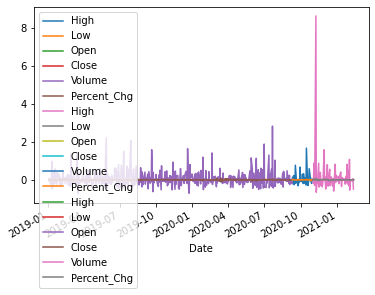

In [24]:
train = dataset_delta_AMAZN[:'2020-09-11']
val = dataset_delta_AMAZN['2020-09-11':'2020-11-01']
test = dataset_delta_AMAZN['2020-11-01':] #2021-02-12
ax = train.plot()
val.plot(ax=ax)
test.plot(ax=ax)

In [25]:
def train_test_val(dataset_delta_AMAZN, date1='2020-09-11', date2='2020-11-01'):    
    train = dataset_delta_AMAZN[:date1]#'2020-09-11'
    val = dataset_delta_AMAZN[date1:date2]
    test = dataset_delta_AMAZN[date2:] #2021-02-12
    ax = train.plot()
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

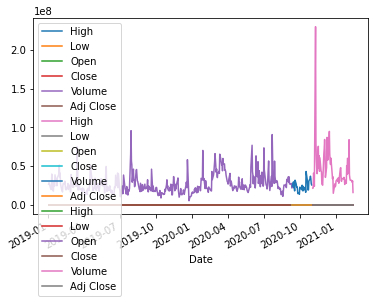

In [26]:
train, val, test= train_test_val(df)

In [27]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
val_scaled = scaler.transform(val)

In [28]:
train_scaled.shape, val_scaled.shape, test_scaled.shape

((428, 6), (36, 6), (71, 6))

In [29]:
look_back = 10
batch_size=3
col_index = {v:k for k,v in enumerate(train.columns)}
col_index

{'High': 0, 'Low': 1, 'Open': 2, 'Close': 3, 'Volume': 4, 'Adj Close': 5}

In [30]:
col_index['Adj Close']


5

In [31]:
train_data_gen = TimeseriesGenerator(train_scaled, train_scaled[:,col_index['Adj Close']],
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=batch_size)

In [32]:
val_data_gen = TimeseriesGenerator(val_scaled, val_scaled[:,col_index['Adj Close']],
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=batch_size)

In [39]:
test_data_gen = TimeseriesGenerator(test_scaled, test_scaled[:,col_index['Adj Close']],
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=3)

In [40]:
# model = Sequential()
# model.add(LSTM(4, input_shape=(look_back, 1)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(look_back,batch_size)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 50)            10800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)               

In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,callbacks=[early_stop])

Epoch 1/50


ValueError: Error when checking input: expected lstm_7_input to have shape (10, 3) but got array with shape (10, 6)

In [ ]:
model.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def save_model():
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [ ]:
model_params = save_model()

In [ ]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

In [ ]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

In [ ]:
# invert predictions, scale values back to real index/price range.
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [ ]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
dataset = scaler.inverse_transform(df_data) #dataset
dataset.shape

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Delta + previous close
trainPredictPlot = trainPredictPlot + df_data[1:]
# set empty values
# trainPredictPlot[0:look_back, :] = np.nan
# trainPredictPlot[len(trainPredict)+look_back:, :] = np.nan


In [ ]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

# Delta + previous close
testPredictPlot = testPredictPlot + df_data[1:]
# set empty values
# testPredictPlot[0:len(trainPredict)+(look_back*2), :] = np.nan
# testPredictPlot[len(dataset):, :] = np.nan

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(12,6))
plt.plot(dataset + df_data[1:])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Valid','Train','Predictions'],loc='upper left')
#plt.show()


In [ ]:
# plot baseline and predictions
plt.plot(dataset + df_data[:-1])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
# def get_quote(new_df):
#     #get last 60days closing values and convert datframe to an array
#     last_60_days = new_df[-60:].values #converts to array
#     #scale data
#     last_60_days_scaled = scaler.transform(last_60_days)
#     #create empty list
#     x_test = []
#     #append last 60 days to x_test
#     x_test.append(last_60_days_scaled)
#     #conert x_test to a numpy array
#     x_test = np.array(x_test)
#     # #reshape the data
#     x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#     #get the predicted scaled price
#     pred_price = model.predict(x_test)
#     #undo the scaling 
#     pred_price = scaler.inverse_transform(pred_price) 
#     #what model thinks predicted price will be for 12/18/2019
#     #the actual prcie was $69.94
#     #DAL: 58.58, 2021-1-11 40.19
#     return pred_price    

In [ ]:
#get_quote(dataset)

### Multi-Series Forecasting

In [ ]:
df_multi = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN']], start='12-31-2018',end='today',plot=True, stock_value='Adj Close');
df_multi #;

In [ ]:
len(df_multi), len(dataset_delta_AMAZN)

In [ ]:
dataset_x = delta_time_series(df_multi)
dataset_x 

In [ ]:
dataset_y= delta_time_series(dataset_delta_AMAZN)
dataset_y 

In [ ]:
# normalize the dataset
scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaler_multi.fit_transform(dataset_x.reshape(-1, 1))
dataset_x = scaler_multi.transform(dataset_x)
dataset_y = scaler_multi.transform(dataset_y)
# split into train and test sets
train_size = int(len(dataset_x) * 0.67)
test_size = len(dataset_x) - train_size
train_x, test_x = dataset_x[0:train_size,:], dataset_x[train_size:len(dataset_x),:]
train_y, test_y = dataset_y[0:train_size,:], dataset_y[train_size:len(dataset_y),:]

In [ ]:
train_x.shape,train_y.shape, test_x.shape, test_y.shape

In [ ]:
train_data_gen = TimeseriesGenerator(train_x, train_y,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=3)

In [ ]:
test_data_gen = TimeseriesGenerator(test_x, test_y,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=1)